Simplest approach to solve the following problem.
The distribution we want to model is p(x|c) where x is the porosity vector of the microstructure (size 27000).

Using a PCA we can find some structure within the latent dimensions. We can see that the first pca component of the microstructure is related to the density. The other components explain part of microstructure variance but they look independent among each other. We can than make this hypothesis and model the marginal distribution p(x|c) over the remaining pca components as independent gaussians.

Given c, we can than identify the first pca component using a simple deterministic regression and the statistics of the gaussians using another model.

At inference the first pca component is deterministically identified while gaussians can be sampled by inferred statistics. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import re
import torch
from torch.utils.data import Dataset, random_split, DataLoader
import numpy as np
import os

In [3]:
path = 'c:/Users/Pietro/Desktop/Porosities/Porosities/'
os.chdir(path)

In [4]:
from Lib.Data import PorosityDistribution



In [5]:
from Lib.Data import extract_microstructures,extract_porosities_points

In [6]:
sample_path = os.getcwd()+'/Job_Assignment_Data/'

In [7]:
extracted_distributions = extract_microstructures(sample_path)
extracted_porosities, density_set = extract_porosities_points(sample_path)

In [8]:
len(extracted_distributions.keys())
train_split = 0.8

train_keys = list(extracted_distributions.keys())[:int(train_split*len(extracted_distributions.keys()))]
test_keys = list(extracted_distributions.keys())[int(train_split*len(extracted_distributions.keys())):]

In [9]:
def get_porosities_per_sample(keys,extracted_distributions):
    porosities = np.zeros((len(keys),extracted_distributions[0].distribution.shape[0]))
    densities = np.zeros((len(keys),1))
    for id,key in enumerate(keys):
        porosities[id,:] = extracted_distributions[key].as_dataframe()['porosity'].values
        densities[id,0] = extracted_distributions[key].density
        
    return porosities,densities

In [10]:
porosities,densities = get_porosities_per_sample(train_keys,extracted_distributions)

In [11]:
porosities.shape

(409, 27000)

In [12]:
from sklearn.decomposition import PCA

pca_comp = 400

pca = PCA(n_components=400)

pca.fit(porosities)

PCA(n_components=400)

In [13]:
pca.explained_variance_ratio_.cumsum()[pca.explained_variance_ratio_.cumsum()<=0.99].shape

(258,)

In [14]:
px.scatter(pca.explained_variance_ratio_)

In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca_comp = 20

pca = PCA(n_components=pca_comp)
scaler_components = StandardScaler()
scaler_density = StandardScaler()

pc_components_porosities = pca.fit_transform(porosities)
scld_pc_components = scaler_components.fit_transform(pc_components_porosities)

data = pd.DataFrame(scld_pc_components, columns=[i for i in range(pca_comp)])

data['density'] = scaler_density.fit_transform(densities)

X, y =  data['density'].values.reshape(-1,1), data[0].values.reshape(-1,1),

In [16]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,density
0,1.118919,0.771955,-0.097848,-0.686000,1.379534,0.162817,-0.101846,-0.177722,0.337585,-0.118720,...,-0.566410,0.669239,0.311500,-0.567209,-0.708629,2.194207,0.967670,-0.102994,0.750537,1.121940
1,-0.766825,-0.003593,0.016279,0.011885,-0.001584,-0.000338,0.047881,0.003730,0.029474,-0.025783,...,0.062214,-0.025197,0.039369,0.013227,-0.006945,-0.029684,0.000732,0.008921,-0.007018,-0.939054
2,2.244718,3.340151,-5.358213,1.260119,4.267079,-1.574571,0.663851,1.042920,1.945331,4.972784,...,-0.921148,-3.100745,-0.185738,-3.269425,-3.457230,0.022133,1.458436,-0.534387,-0.950112,1.570904
3,-0.771769,-0.015853,0.004744,0.015636,0.006978,0.013994,0.043285,-0.000370,0.039091,-0.031080,...,0.058701,-0.011167,0.034096,0.014852,-0.017697,-0.062423,-0.027035,0.018785,-0.006599,-1.105206
4,-0.252617,-0.011564,0.554909,0.143326,-0.148716,-0.021543,-0.282748,-0.058636,-0.377813,0.209376,...,0.037359,-0.765297,-0.060031,0.233635,-0.033704,-0.129647,-0.328425,-0.056488,0.312672,0.287644


<Axes: >

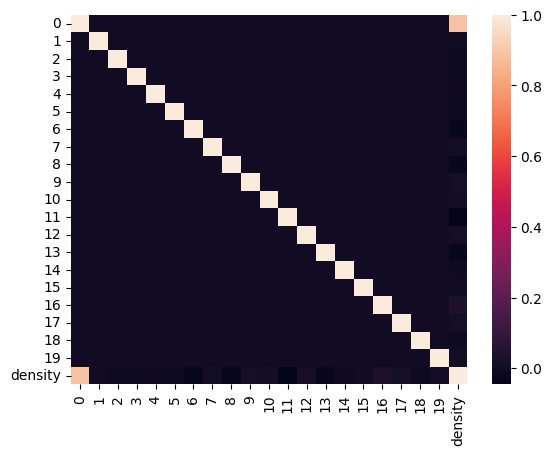

In [17]:
sns.heatmap(data.corr())

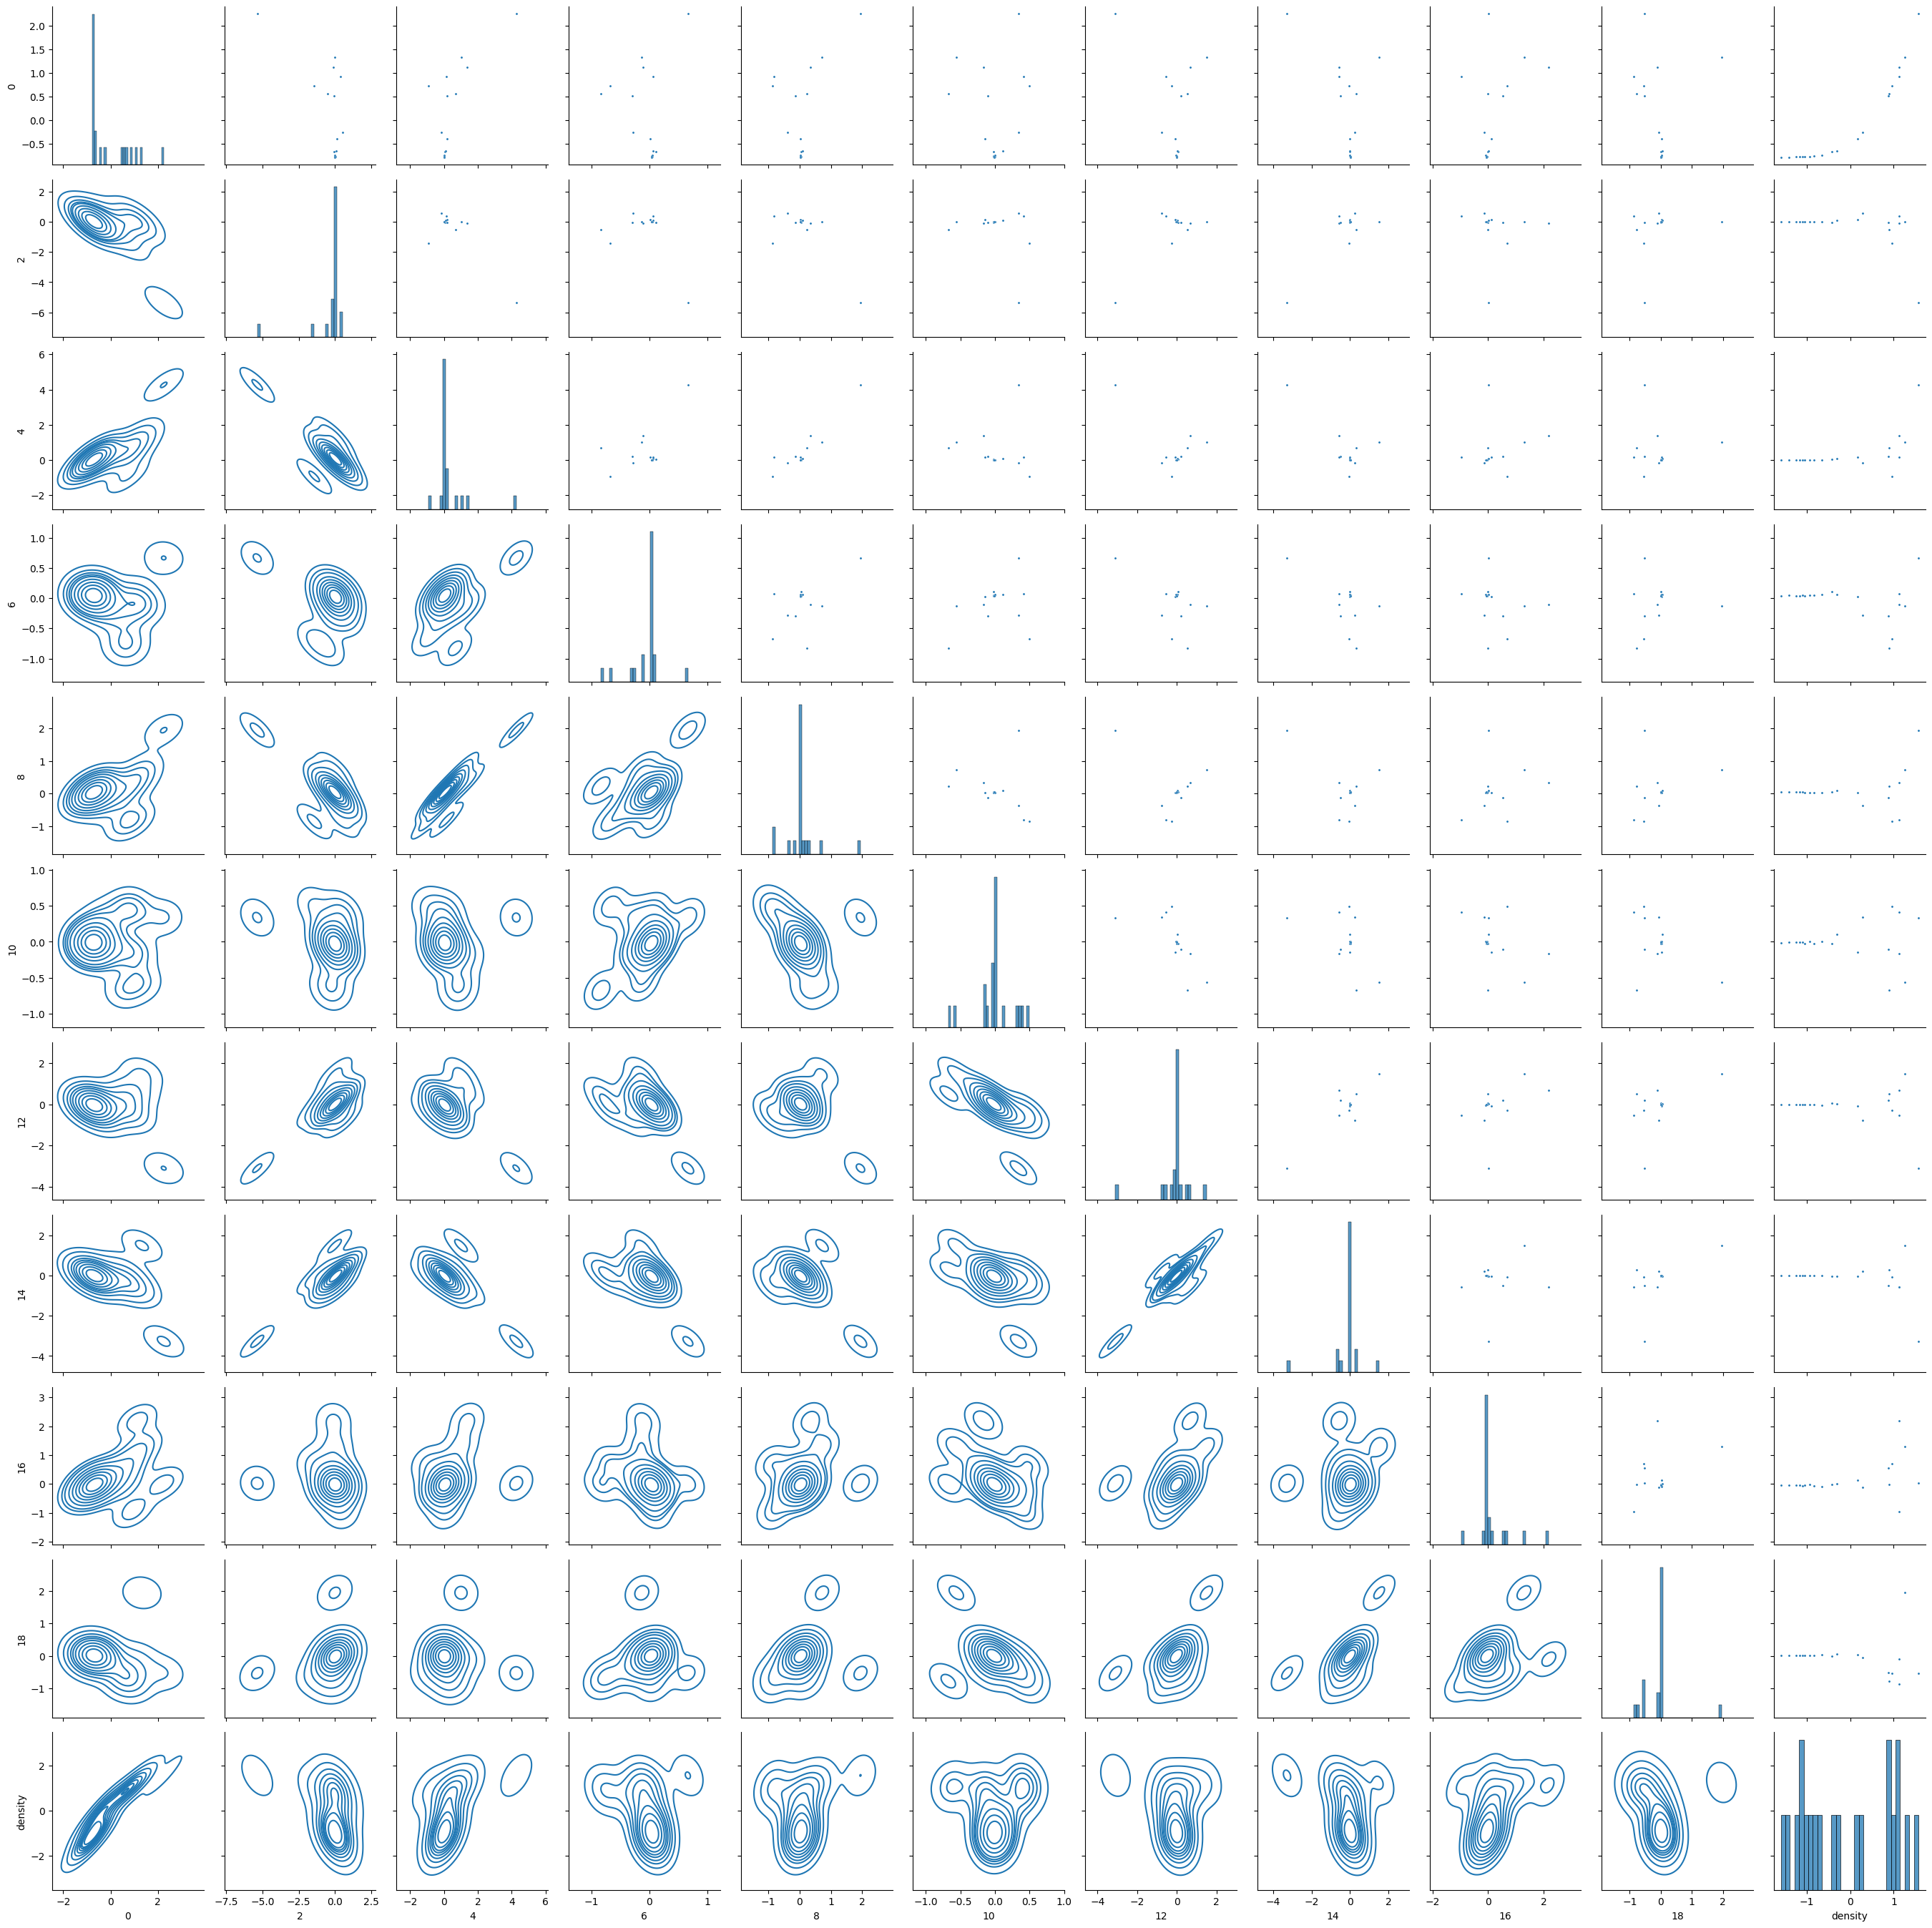

In [18]:

g = sns.PairGrid(data.iloc[:20,::2], diag_sharey=False)
g.map_upper(sns.scatterplot, s=5)
g.map_lower(sns.kdeplot)
g.map_diag(sns.histplot,bins=30)

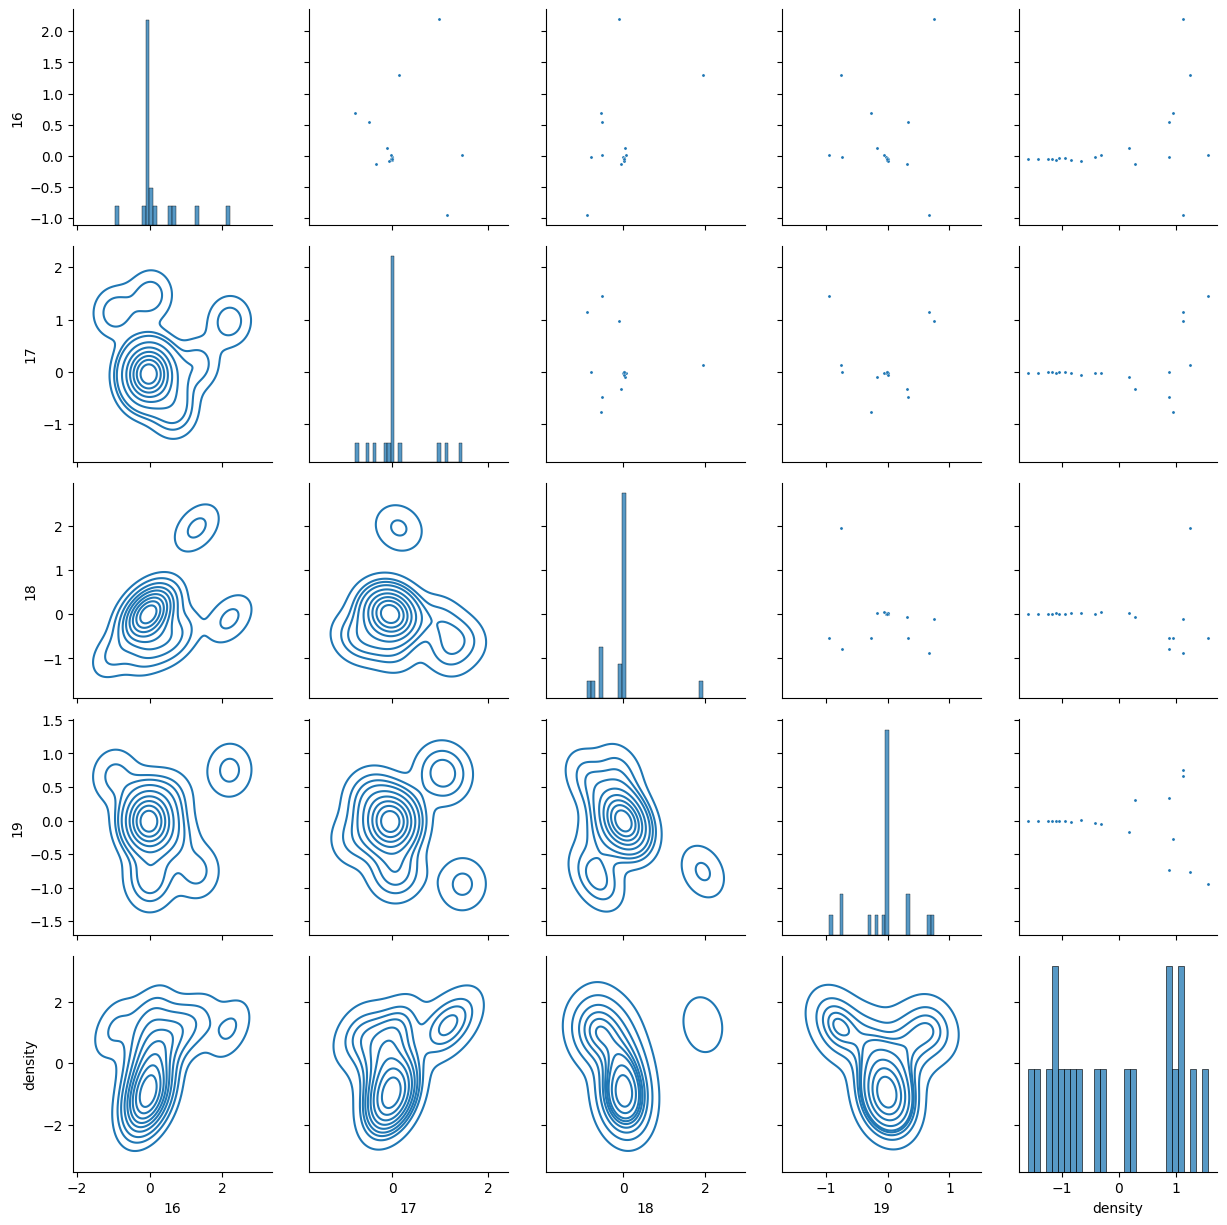

In [19]:
g = sns.PairGrid(data.iloc[:20,-5::], diag_sharey=False)
g.map_upper(sns.scatterplot, s=5)
g.map_lower(sns.kdeplot)
g.map_diag(sns.histplot,bins=30)

In [20]:
px.scatter(data,x='density',y=0)

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


poly_feat = PolynomialFeatures(3)

X = data['density'].values.reshape(-1,1)
y = data[0].values.reshape(-1,1)
X_poly = poly_feat.fit_transform(X)

deterministic_regressor = LinearRegression()
deterministic_regressor.fit(X_poly,y)

y_pred = deterministic_regressor.predict(X_poly)

data['0_rec'] = y_pred.reshape(-1)



In [22]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,density,0_rec
0,1.118919,0.771955,-0.097848,-0.686000,1.379534,0.162817,-0.101846,-0.177722,0.337585,-0.118720,...,0.669239,0.311500,-0.567209,-0.708629,2.194207,0.967670,-0.102994,0.750537,1.121940,1.022848
1,-0.766825,-0.003593,0.016279,0.011885,-0.001584,-0.000338,0.047881,0.003730,0.029474,-0.025783,...,-0.025197,0.039369,0.013227,-0.006945,-0.029684,0.000732,0.008921,-0.007018,-0.939054,-0.769505
2,2.244718,3.340151,-5.358213,1.260119,4.267079,-1.574571,0.663851,1.042920,1.945331,4.972784,...,-3.100745,-0.185738,-3.269425,-3.457230,0.022133,1.458436,-0.534387,-0.950112,1.570904,2.223068
3,-0.771769,-0.015853,0.004744,0.015636,0.006978,0.013994,0.043285,-0.000370,0.039091,-0.031080,...,-0.011167,0.034096,0.014852,-0.017697,-0.062423,-0.027035,0.018785,-0.006599,-1.105206,-0.774429
4,-0.252617,-0.011564,0.554909,0.143326,-0.148716,-0.021543,-0.282748,-0.058636,-0.377813,0.209376,...,-0.765297,-0.060031,0.233635,-0.033704,-0.129647,-0.328425,-0.056488,0.312672,0.287644,-0.270579


In [23]:
X.shape

(409, 1)

In [24]:

fig = px.scatter(x=X.reshape(-1), y=y.reshape(-1),
                 opacity=0.5,  # Set opacity for better visualization
                 title="Regression Plot: Actual vs. Predicted First Principal Component")

fig.add_scatter(x=X.reshape(-1), y=y_pred.reshape(-1),
                 opacity=0.5, mode='markers')  # Set opacity for better visualization)

fig.show()

In [25]:
fig = px.scatter(data,x=0, y='0_rec',
                 opacity=0.5,  # Set opacity for better visualization
                 trendline="ols",  # Add trendline using Ordinary Least Squares
                 title="Regression Plot: Actual vs. Predicted Density")

# Add ideal line (y = x)
x_range = np.linspace(data[0].min(), data['0_rec'].max(), 100)
fig.add_scatter(x=x_range, y=x_range, mode='lines',
                line=dict(color='red', dash='dash'),
                name='Ideal Line (y = x)')

fig.update_layout(
    xaxis_title="Actual Density",
    yaxis_title="Predicted Density"
)

fig.show()

In [26]:
stochastic_dimensions = [i for i in range(1,pca_comp)]
stochastic_dimensions.append('density')
stochastic_df = data[stochastic_dimensions].copy()



In [27]:
stochastic_df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,density
0,0.771955,-0.097848,-0.686000,1.379534,0.162817,-0.101846,-0.177722,0.337585,-0.118720,-0.166492,-0.566410,0.669239,0.311500,-0.567209,-0.708629,2.194207,0.967670,-0.102994,0.750537,1.121940
1,-0.003593,0.016279,0.011885,-0.001584,-0.000338,0.047881,0.003730,0.029474,-0.025783,0.002132,0.062214,-0.025197,0.039369,0.013227,-0.006945,-0.029684,0.000732,0.008921,-0.007018,-0.939054
2,3.340151,-5.358213,1.260119,4.267079,-1.574571,0.663851,1.042920,1.945331,4.972784,0.337857,-0.921148,-3.100745,-0.185738,-3.269425,-3.457230,0.022133,1.458436,-0.534387,-0.950112,1.570904
3,-0.015853,0.004744,0.015636,0.006978,0.013994,0.043285,-0.000370,0.039091,-0.031080,-0.008603,0.058701,-0.011167,0.034096,0.014852,-0.017697,-0.062423,-0.027035,0.018785,-0.006599,-1.105206
4,-0.011564,0.554909,0.143326,-0.148716,-0.021543,-0.282748,-0.058636,-0.377813,0.209376,0.342190,0.037359,-0.765297,-0.060031,0.233635,-0.033704,-0.129647,-0.328425,-0.056488,0.312672,0.287644


In [28]:
density_bins=30
stochastic_df['density_bins'] = pd.cut(stochastic_df['density'],bins=density_bins)

means = stochastic_df.groupby(['density_bins']).mean()
stds = stochastic_df.groupby(['density_bins']).std()

C:\Users\Pietro\AppData\Local\Temp\ipykernel_10292\2065903162.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Pietro\AppData\Local\Temp\ipykernel_10292\2065903162.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [29]:
means.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,density
density_bins,,,,,,,,,,,,,,,,,,,,
"(-1.759, -1.639]",-0.006166,0.013378,0.020300,0.004932,0.006446,0.040719,-0.008967,0.039187,-0.021713,-0.011634,0.067443,-0.016063,0.037638,0.007940,-0.000632,-0.048103,-0.015093,0.012277,-0.006842,-1.687419
"(-1.639, -1.522]",-0.006166,0.013378,0.020300,0.004932,0.006446,0.040719,-0.008967,0.039187,-0.021713,-0.011634,0.067443,-0.016063,0.037638,0.007940,-0.000632,-0.048103,-0.015093,0.012277,-0.006842,-1.575381
"(-1.522, -1.405]",-0.005893,0.012631,0.020329,0.005077,0.006180,0.041030,-0.009303,0.039838,-0.021024,-0.011132,0.068091,-0.016351,0.037538,0.008113,-0.000248,-0.047720,-0.015632,0.012462,-0.006636,-1.461594
"(-1.405, -1.288]",-0.004093,0.012546,0.019194,0.004758,0.005337,0.040463,-0.009562,0.038723,-0.021849,-0.011153,0.067399,-0.016689,0.036968,0.008046,0.000455,-0.048669,-0.016573,0.011605,-0.007232,-1.338798
"(-1.288, -1.171]",-0.007263,0.013917,0.020378,0.002896,0.007345,0.040843,-0.009564,0.038971,-0.020274,-0.010216,0.067189,-0.016256,0.037656,0.006997,-0.002339,-0.048073,-0.013651,0.010391,-0.008523,-1.230704


In [30]:
dim_means = means.iloc[:,:-1]
dim_stds = stds.iloc[:,:-1]

densities = np.zeros_like(dim_stds.values)
dim_coord = np.zeros_like(densities)

for i in range(densities.shape[0]):
    densities[i,:] = means['density'].iloc[i]
    dim_coord[i,:] = dim_stds.columns.values
    
densities = pd.DataFrame(densities,columns=dim_means.columns,index=dim_means.index)
dim_coord = pd.DataFrame(dim_coord,columns=dim_means.columns,index=dim_means.index)

In [31]:
dim_means.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
density_bins,,,,,,,,,,,,,,,,,,,
"(-1.759, -1.639]",-0.006166,0.013378,0.020300,0.004932,0.006446,0.040719,-0.008967,0.039187,-0.021713,-0.011634,0.067443,-0.016063,0.037638,0.007940,-0.000632,-0.048103,-0.015093,0.012277,-0.006842
"(-1.639, -1.522]",-0.006166,0.013378,0.020300,0.004932,0.006446,0.040719,-0.008967,0.039187,-0.021713,-0.011634,0.067443,-0.016063,0.037638,0.007940,-0.000632,-0.048103,-0.015093,0.012277,-0.006842
"(-1.522, -1.405]",-0.005893,0.012631,0.020329,0.005077,0.006180,0.041030,-0.009303,0.039838,-0.021024,-0.011132,0.068091,-0.016351,0.037538,0.008113,-0.000248,-0.047720,-0.015632,0.012462,-0.006636
"(-1.405, -1.288]",-0.004093,0.012546,0.019194,0.004758,0.005337,0.040463,-0.009562,0.038723,-0.021849,-0.011153,0.067399,-0.016689,0.036968,0.008046,0.000455,-0.048669,-0.016573,0.011605,-0.007232
"(-1.288, -1.171]",-0.007263,0.013917,0.020378,0.002896,0.007345,0.040843,-0.009564,0.038971,-0.020274,-0.010216,0.067189,-0.016256,0.037656,0.006997,-0.002339,-0.048073,-0.013651,0.010391,-0.008523


In [32]:
dim_stds.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
density_bins,,,,,,,,,,,,,,,,,,,
"(-1.759, -1.639]",0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
"(-1.639, -1.522]",5.645630e-17,1.225271e-17,7.681689e-17,1.478082e-16,1.037584e-16,3.575757e-17,9.475571e-17,1.423742e-16,5.292091e-17,1.457695e-16,1.866492e-16,1.214417e-16,1.627150e-16,1.520170e-16,1.130682e-16,7.321547e-17,2.826706e-16,1.002678e-16,2.865166e-16
"(-1.522, -1.405]",1.220401e-03,1.038977e-03,1.479093e-03,1.551604e-03,1.674606e-03,1.214262e-03,2.212668e-03,1.821211e-03,1.885619e-03,1.436428e-03,1.757192e-03,1.253668e-03,1.323169e-03,1.474060e-03,1.523541e-03,1.182122e-03,1.204700e-03,1.575435e-03,1.803711e-03
"(-1.405, -1.288]",3.191310e-03,2.313278e-03,2.640885e-03,3.493774e-03,3.099927e-03,3.300828e-03,4.095449e-03,2.039587e-03,1.555290e-03,2.372535e-03,3.531627e-03,2.221413e-03,3.770982e-03,3.801227e-03,2.273879e-03,2.604862e-03,2.826806e-03,3.145072e-03,1.934601e-03
"(-1.288, -1.171]",3.766692e-03,3.022996e-03,3.472853e-03,3.499090e-03,2.541335e-03,3.297457e-03,3.917163e-03,2.534225e-03,3.095869e-03,3.583239e-03,4.388366e-03,4.814250e-03,4.184232e-03,3.808307e-03,3.836064e-03,4.484715e-03,5.461378e-03,4.080478e-03,2.707106e-03


In [33]:
densities.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
density_bins,,,,,,,,,,,,,,,,,,,
"(-1.759, -1.639]",-1.687419,-1.687419,-1.687419,-1.687419,-1.687419,-1.687419,-1.687419,-1.687419,-1.687419,-1.687419,-1.687419,-1.687419,-1.687419,-1.687419,-1.687419,-1.687419,-1.687419,-1.687419,-1.687419
"(-1.639, -1.522]",-1.575381,-1.575381,-1.575381,-1.575381,-1.575381,-1.575381,-1.575381,-1.575381,-1.575381,-1.575381,-1.575381,-1.575381,-1.575381,-1.575381,-1.575381,-1.575381,-1.575381,-1.575381,-1.575381
"(-1.522, -1.405]",-1.461594,-1.461594,-1.461594,-1.461594,-1.461594,-1.461594,-1.461594,-1.461594,-1.461594,-1.461594,-1.461594,-1.461594,-1.461594,-1.461594,-1.461594,-1.461594,-1.461594,-1.461594,-1.461594
"(-1.405, -1.288]",-1.338798,-1.338798,-1.338798,-1.338798,-1.338798,-1.338798,-1.338798,-1.338798,-1.338798,-1.338798,-1.338798,-1.338798,-1.338798,-1.338798,-1.338798,-1.338798,-1.338798,-1.338798,-1.338798
"(-1.288, -1.171]",-1.230704,-1.230704,-1.230704,-1.230704,-1.230704,-1.230704,-1.230704,-1.230704,-1.230704,-1.230704,-1.230704,-1.230704,-1.230704,-1.230704,-1.230704,-1.230704,-1.230704,-1.230704,-1.230704


In [34]:
dim_coord.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
density_bins,,,,,,,,,,,,,,,,,,,
"(-1.759, -1.639]",1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0
"(-1.639, -1.522]",1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0
"(-1.522, -1.405]",1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0
"(-1.405, -1.288]",1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0
"(-1.288, -1.171]",1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0


In [35]:
X = np.zeros((densities.shape[0],densities.shape[1],4))
X[:,:,0] = dim_means.values
X[:,:,1] = dim_stds.values
X[:,:,2] = densities.values
X[:,:,3] = dim_coord.values

gaussian_parameters = pd.DataFrame(X.reshape(densities.shape[0]*densities.shape[1],4),columns=['dim_mean','dim_std','density','dim'])

In [36]:
gaussian_parameters.head()

,dim_mean,dim_std,density,dim
0,-0.006166,0.0,-1.687419,1.0
1,0.013378,0.0,-1.687419,2.0
2,0.020300,0.0,-1.687419,3.0
3,0.004932,0.0,-1.687419,4.0
4,0.006446,0.0,-1.687419,5.0


In [37]:
px.scatter_3d(gaussian_parameters,x='density',y='dim',z='dim_std',color='dim_std')

In [38]:
px.scatter_3d(gaussian_parameters,x='density',y='dim',z='dim_mean',color='dim_mean')

In [39]:
gaussian_parameters.head()

,dim_mean,dim_std,density,dim
0,-0.006166,0.0,-1.687419,1.0
1,0.013378,0.0,-1.687419,2.0
2,0.020300,0.0,-1.687419,3.0
3,0.004932,0.0,-1.687419,4.0
4,0.006446,0.0,-1.687419,5.0


In [40]:
X_test = np.random.rand(500,2)

In [41]:
from sklearn.neighbors import KNeighborsRegressor

X = gaussian_parameters[['density','dim']].values
y = gaussian_parameters[['dim_mean','dim_std']].values

statistics_regressor = KNeighborsRegressor(n_neighbors=4)

statistics_regressor.fit(X,y)

y_pred = statistics_regressor.predict(X)

In [42]:
gaussian_parameters['rec_mean'] = y_pred[:,0]
gaussian_parameters['rec_std'] = y_pred[:,1]

In [43]:
px.scatter_3d(gaussian_parameters,x='density',y='dim',z='rec_std',color='rec_std')

In [44]:
px.scatter_3d(gaussian_parameters,x='density',y='dim',z='rec_mean',color='rec_mean')

In [45]:
X_dim_test = np.random.randint(1,pca_comp-1,size=1000)
X_density_test = np.random.rand(1000)
X_test = np.zeros((1000,2))
res = np.zeros((1000,4))

X_test[:,0] = X_density_test
X_test[:,1] = X_dim_test
res[:,0] = X_density_test
res[:,1] = X_dim_test

In [46]:
y_test = statistics_regressor.predict(X_test)
res[:,2:] = y_test

In [47]:
res = pd.DataFrame(res, columns=['density','dim','rec_mean','rec_std'])



In [48]:
px.scatter_3d(res,x='density',y='dim',z='rec_mean',color='rec_mean')

In [49]:
px.scatter_3d(res,x='density',y='dim',z='rec_std',color='rec_std')

In [50]:
import numpy as np

def generate(samples, density,deterministic=True):

    components = np.zeros((samples,pca_comp))
    sc_density = scaler_density.transform(np.array([[density]]))

    principal = deterministic_regressor.predict(poly_feat.transform(sc_density))
    components[:,0]=principal
    sc_density = sc_density[0,0]

    for dimension in range(1,pca_comp):
        
        X = np.array([[sc_density,dimension]])
        
        statistics = statistics_regressor.predict(X)
        #print(statistics,dimension)
        mean_dimension = statistics[0,0]
        std_dimensions = statistics[0,1]
        
        components[:,dimension] = np.random.normal(loc = mean_dimension, scale = std_dimensions,size=samples)
        if deterministic:
            components[:,dimension] = mean_dimension
        
    porosities = pca.inverse_transform(scaler_components.inverse_transform(components))

    #print(porosities.shape)
        
    return porosities
    

In [51]:
porosities = generate(100,0.2)

In [52]:
porosities

array([[ 0.0027716 , -0.001303  , -0.00581281, ..., -0.00537198,
         0.00175098, -0.00130464],
       [ 0.0027716 , -0.001303  , -0.00581281, ..., -0.00537198,
         0.00175098, -0.00130464],
       [ 0.0027716 , -0.001303  , -0.00581281, ..., -0.00537198,
         0.00175098, -0.00130464],
       ...,
       [ 0.0027716 , -0.001303  , -0.00581281, ..., -0.00537198,
         0.00175098, -0.00130464],
       [ 0.0027716 , -0.001303  , -0.00581281, ..., -0.00537198,
         0.00175098, -0.00130464],
       [ 0.0027716 , -0.001303  , -0.00581281, ..., -0.00537198,
         0.00175098, -0.00130464]], shape=(100, 27000))

In [53]:
density = 0.8
porosities = generate(100,density)


template = np.load(os.path.join(sample_path, 'distribution_000_0.821.npy'))

array_data = template
array_data[:,3] = porosities[0,:]
# Store in the dictionary
sample = PorosityDistribution(array_data, density=density)
sample.plot_porosity_distribution(porosity=0.035)